In [204]:
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import csv

In [205]:
paths = glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/k401-activedrops/img_*********_gfp-4x_000.tif")
paths = sorted(paths) # 1104 images in total
print(len(paths))

1104


In [206]:
calibrationCurvePaths = glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/***ugml.tif")
calibrationCurvePaths = sorted(calibrationCurvePaths) # 9 sample images used to get an equation for Protein Concentration
calibrationCurvePaths

['/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/000ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/002ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/005ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/010ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/020ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/040ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/080ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/160ugml.tif',
 '/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/320ugml.tif']

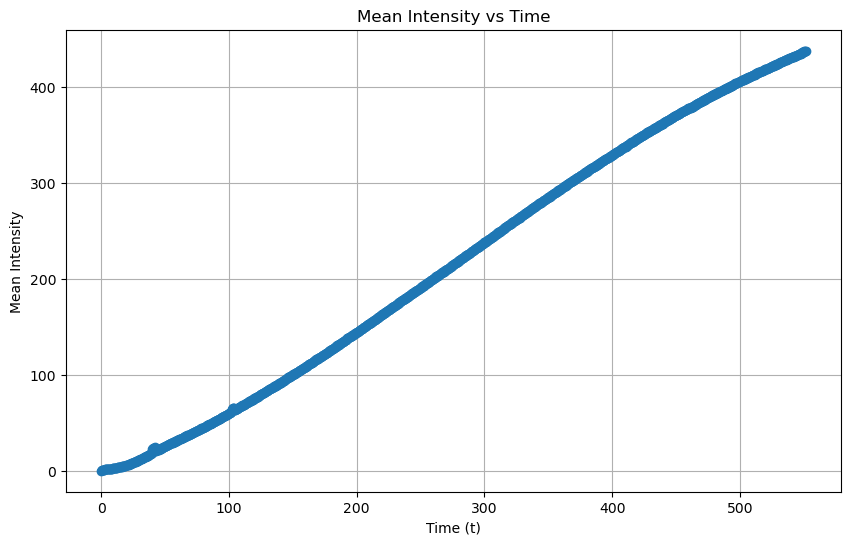

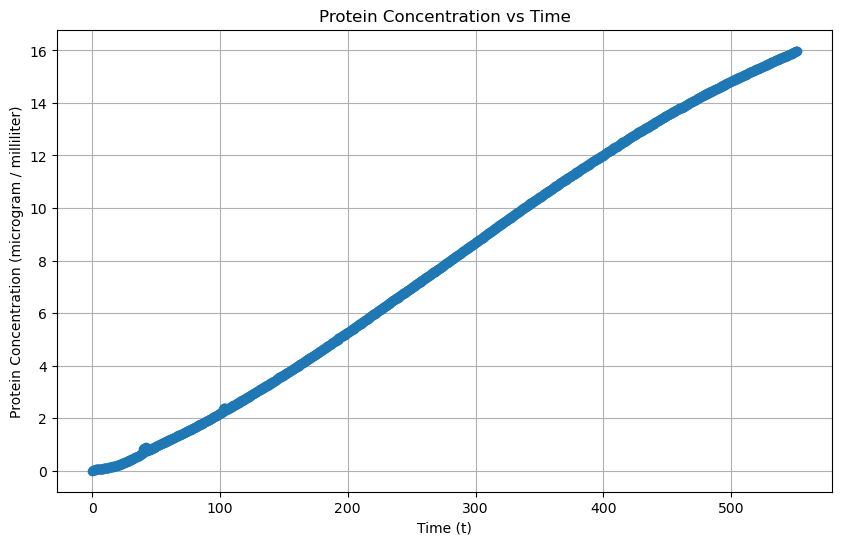

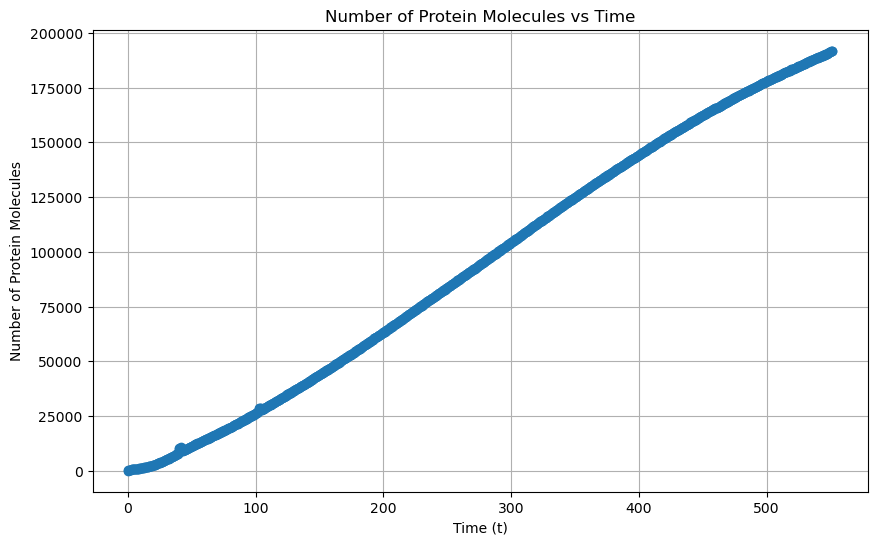

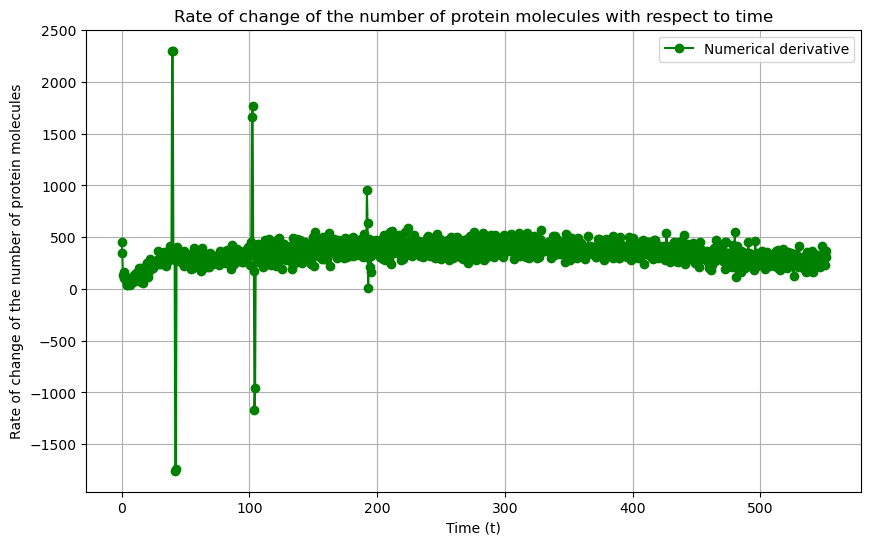

In [207]:
timeValues_List = list()
meanIntensity_List = list()
meanIntensity_CalibrationCurve_List = list()
proteinConcentration_List = list()
numberOfProteinMolecules_List = list()
rateOfChangeProteinMolecules_List = list()

# This function utilizes the images taken for the experiment of the K401 motor protein
def calculateMeanIntensity(paths):

    for i in range(0,len(paths)): 

        # Load the image as a matrix
        image_path = paths[i]
        image_matrix = io.imread(image_path)

        meanIntensity = image_matrix.mean()
        meanIntensity_List.append(meanIntensity)

# This function utilizes 9 sample images to analyze the relationship between "Mean Intensity" and "Protein Concentration"
def getConcentration(calibrationCurvePaths): # This function takes a list of image paths, as an argument
    
    for i in range(0, len(calibrationCurvePaths)):

        # Load the image as a matrix
        image_path = calibrationCurvePaths[i]
        image_matrix = io.imread(image_path)

        meanIntensity = image_matrix.mean()
        meanIntensity_CalibrationCurve_List.append(meanIntensity) 

    df = pd.DataFrame(meanIntensity_CalibrationCurve_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Protein Concentration (microgram / mililiter)", 0:"Mean Intensity"})
    sampleConcentration_Values = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    df["Protein Concentration (microgram / mililiter)"] = sampleConcentration_Values

    # Get the equation (linear) of best fit for the Protein Concentration
    x = df["Protein Concentration (microgram / mililiter)"]
    y = df["Mean Intensity"]

    slope, intercept = np.polyfit(x,y,1) # Multiple return values is allowed in Python
    
    """
    line_of_best_fit = slope * x + intercept
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df["Protein Concentration (microgram / mililiter)"], df["Mean Intensity"], marker='o', linestyle='none', label='Data points')
    plt.plot(x, line_of_best_fit, label=f'Line of Best Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
    plt.title('Mean Intensity vs Protein Concentration')
    plt.xlabel('Protein Concentration (microgram / milliliter)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()
    """

    # Transform the dependent variables

    for i in range(0, len(meanIntensity_List)):
        proteinConcentration = (meanIntensity_List[i] - intercept) / slope
        proteinConcentration_List.append(proteinConcentration)

def constructDataFrames(timeInterval):

    global meanIntensity_List
    global proteinConcentration_List

    minimumIntensityValue = min(meanIntensity_List)
    adjustedMeanIntensity_List = [x - minimumIntensityValue for x in meanIntensity_List] # Subsract the minimum mean intensity value from ALL values
    meanIntensity_List = adjustedMeanIntensity_List

    minimumProteinConcentration = min(proteinConcentration_List)
    adjustedProteinConcentration_List = [x - minimumProteinConcentration for x in proteinConcentration_List]
    proteinConcentration_List = adjustedProteinConcentration_List

    df = pd.DataFrame(meanIntensity_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Mean Intensity"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Mean Intensity'], marker='o')
    plt.title('Mean Intensity vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.show()

    df2 = pd.DataFrame(proteinConcentration_List).reset_index()
    df2 = df2.rename(columns={"index":"Time (min)", 0:"Protein Concentration (microgram / milliliter)"})
    df2["Time (min)"] = df2["Time (min)"] * timeInterval # Manipulate the "time" values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df2['Time (min)'], df2['Protein Concentration (microgram / milliliter)'], marker='o')
    plt.title('Protein Concentration vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (microgram / milliliter)')
    plt.grid(True)
    plt.show()

def getNumberOfProteinMolecules(dropletVolume, timeInterval):

    global numberOfProteinMolecules_List
    proteinMass_List = [i * dropletVolume for i in proteinConcentration_List] # List comprehension technique
    numberOfProteinMolecules_List = [j * 6000000000 for j in proteinMass_List] # This expression was derived from several intermediate calculations

    df = pd.DataFrame(numberOfProteinMolecules_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Number of Protein Molecules"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    plt.grid(True)
    plt.show()

def getRateOfChangeProteinMolecules(timeInterval):
    
    global timeValues_List
    global rateOfChangeProteinMolecules_List
    
    p_vals = np.array(numberOfProteinMolecules_List) # Converts a Python list to a numpy array
    length = len(numberOfProteinMolecules_List)
    maxTimeValue = (length - 1) * timeInterval 
    t_vals = np.linspace(0, maxTimeValue, length) # Creates a numpy array
    timeValues_List = t_vals.tolist()

    # Estimate the numerical derivative of the number of protein molecules with respect to time
    dp_dt = np.gradient(p_vals, t_vals)
    rateOfChangeProteinMolecules_List = dp_dt.tolist()
    
    # Plot the estimated derivative
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, dp_dt, label='Numerical derivative', marker='o', color="green")
    plt.xlabel('Time (t)')
    plt.ylabel('Rate of change of the number of protein molecules')
    plt.title('Rate of change of the number of protein molecules with respect to time')
    plt.legend()
    plt.grid(True)
    plt.show()

def saveData(fileName): # Saves the data to a CSV file

    # save dataframes to csv files
    dataFile = open(fileName,'w',newline="")
    writerCSV = csv.writer(dataFile)
    headerRow = list()
    headerRow.append("Time")
    headerRow.append("Mean Intensity")
    headerRow.append("Protein Concentration")
    headerRow.append("Number of Protein Molecules (PM)")
    headerRow.append("Rate of Change of Number of PM")
    writerCSV.writerow(headerRow)
    for i in range(0, len(meanIntensity_List)):
        dataRow = list()
        dataRow.append(timeValues_List[i])
        dataRow.append(meanIntensity_List[i])
        dataRow.append(proteinConcentration_List[i])
        dataRow.append(numberOfProteinMolecules_List[i])
        dataRow.append(rateOfChangeProteinMolecules_List[i])
        writerCSV.writerow(dataRow)
    dataFile.close()

def runAnalysis(paths,calibrationCurvePaths, timeInterval, dropletVolume, fileName):
    calculateMeanIntensity(paths) # 1st function to be called
    getConcentration(calibrationCurvePaths) # 2nd function to be called
    constructDataFrames(timeInterval) # Time interval is passed in minutes. # 3th function to be called
    getNumberOfProteinMolecules(dropletVolume, timeInterval) # For the experiment of the K401 protein, the droplet had a volume of 2 microliters. 4th function to be called
    getRateOfChangeProteinMolecules(timeInterval) # 5th function to be called
    saveData(fileName) # 6th function to be called

runAnalysis(paths, calibrationCurvePaths, 0.5, 0.000002, "proteinsData.csv")

